In [103]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Bing
import requests
import folium
from wordcloud import WordCloud, STOPWORDS

cottecting to mongoDB:

In [104]:
client = MongoClient("mongodb://localhost:27017/")
db = client["project1"]
restaurants_collection = db["Restaurants"]
people_collection = db["people"]

In [105]:
restaurants_data = pd.DataFrame(list(restaurants_collection.find()))
print(restaurants_data.head())

                        _id              Name       Street Address  \
0  6481ce0f909234df3c1c6aa1           trdgtdc               string   
1  6481ce0f909234df3c1c6aa2  Table Talk Diner  2521 South Rd Ste C   
2  6481ce0f909234df3c1c6aa3       Sixty Vines     3701 Dallas Pkwy   
3  6481ce0f909234df3c1c6aa4      The Clam Bar    3914 Brewerton Rd   
4  6481ce0f909234df3c1c6aa5       E Tutto Qua     270 Columbus Ave   

                       Location                                      Type  \
0                        string                                    string   
1   Poughkeepsie, NY 12601-5476      American, Diner, Vegetarian Friendly   
2          Plano, TX 75093-7777   American, Wine Bar, Vegetarian Friendly   
3            Syracuse, NY 13212                    American, Bar, Seafood   
4  San Francisco, CA 94133-4518                   Seafood, Italian, Pizza   

    Reviews  No of Reviews                                           Comments  \
0  4.000000           84.0         

In [106]:
restaurants_data['state'] = restaurants_data['Location'].str.split(',').str[-1].str.strip().str[:2]
restaurants_data['city'] = restaurants_data['Location'].str.split(',').str[0]

In [107]:
# print(restaurants_data.dtypes)
restaurants_data

,_id,Name,Street Address,Location,Type,Reviews,No of Reviews,Comments,Contact Number,coordinates,Score,Street_Address,No_of_Reviews,Contact_Number,state,city
0,6481ce0f909234df3c1c6aa1,trdgtdc,string,string,string,4.000000,84.0,string,string,NaN,NaN,NaN,NaN,NaN,st,string
1,6481ce0f909234df3c1c6aa2,Table Talk Diner,2521 South Rd Ste C,"Poughkeepsie, NY 12601-5476","American, Diner, Vegetarian Friendly",4.000000,256.0,Waitress was very friendly but a little pricey...,+1 845-849-2839,"{'type': 'Point', 'coordinates': [-73.931143, ...",3.555348,NaN,NaN,NaN,NY,Poughkeepsie
2,6481ce0f909234df3c1c6aa3,Sixty Vines,3701 Dallas Pkwy,"Plano, TX 75093-7777","American, Wine Bar, Vegetarian Friendly",4.500000,235.0,Not sure why I went there for the second time....,+1 469-620-8463,NaN,NaN,NaN,NaN,NaN,TX,Plano
3,6481ce0f909234df3c1c6aa4,The Clam Bar,3914 Brewerton Rd,"Syracuse, NY 13212","American, Bar, Seafood",4.000000,285.0,Doesn't look like much from the outside but wa...,+1 315-458-1662,NaN,NaN,NaN,NaN,NaN,NY,Syracuse
4,6481ce0f909234df3c1c6aa5,E Tutto Qua,270 Columbus Ave,"San Francisco, CA 94133-4518","Seafood, Italian, Pizza",4.499645,1407.0,,+1 415-989-1002,NaN,NaN,NaN,NaN,NaN,CA,San Francisco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,6481ce0f909234df3c1c767c,City Vineyard,233 West Street,"New York City, NY 10013","American, Bar, Seafood",4.500000,374.0,"Came here to see Andrea Gibson perform, we wer...",+1 646-677-8350,NaN,NaN,NaN,NaN,NaN,NY,New York City
3026,6481ce0f909234df3c1c767d,BRIO Tuscan Grille,3710 US Highway 9,"Freehold, NJ 07728-4801","Steakhouse, Italian, Bar",4.000000,211.0,We come to Brio once a month. They are good fo...,+1 732-683-1045,NaN,NaN,NaN,NaN,NaN,NJ,Freehold
3027,6481ce0f909234df3c1c767e,Maywood Pancake house,92 W Pleasant Ave,"Maywood, NJ 07607-1336","American, Vegan Options, Gluten Free Options",4.000000,87.0,Stopped in yesterday for Breakfast. When in Je...,+1 201-880-7842,NaN,NaN,NaN,NaN,NaN,NJ,Maywood
3028,6481ce0f909234df3c1c767f,Porto Leggero,Harborside Financial Center - Plaza 5,"Jersey City, NJ 07311","Italian, Vegetarian Friendly, Vegan Options",4.500000,183.0,First time for dinner. 2 couples. Delicious mu...,+1 201-434-3200,NaN,NaN,NaN,NaN,NaN,NJ,Jersey City


In [108]:
restaurants_data['Reviews'] = pd.to_numeric(restaurants_data['Reviews'], errors='coerce')
restaurants_data['No of Reviews'] = pd.to_numeric(restaurants_data['No of Reviews'], errors='coerce')

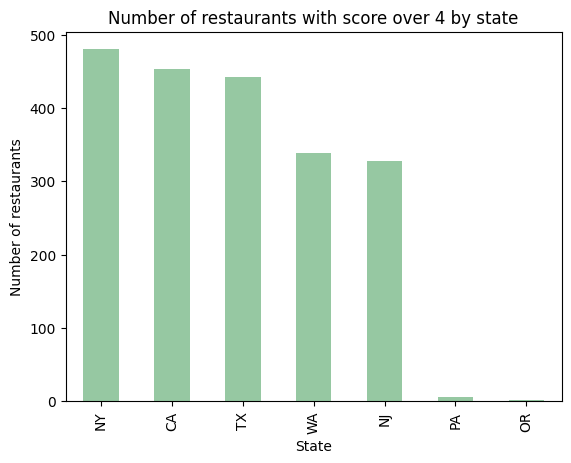

In [109]:
filtered_df = restaurants_data[restaurants_data['Reviews'] > 4]
state_counts = filtered_df['state'].value_counts()
state_counts.plot(kind='bar', color = '#96C8A2')
plt.title('Number of restaurants with score over 4 by state')
plt.xlabel('State')
plt.ylabel('Number of restaurants')
plt.show()

In [110]:
people_data = pd.DataFrame(list(people_collection.find()))
print(people_data.head())

                        _id            name  \
0  6481d2d5cb58a55021eae6ab      Mia Walker   
1  6481d2d7cb58a55021eae6ac   Amelia Wilson   
2  6481d2d9cb58a55021eae6ad  William Garcia   
3  6481d2dbcb58a55021eae6ae      Jack Allen   
4  6481d2ddcb58a55021eae6af  Amelia Johnson   

                                  restaurant_visited  
0  [{'restaurant': 'Via Real Gourmet Mexican', 's...  
1  [{'restaurant': 'Frankie Feds', 'score': 4.0},...  
2  [{'restaurant': 'Landry's Seafood House', 'sco...  
3         [{'restaurant': 'L'Artusi', 'score': 4.0}]  
4  [{'restaurant': 'Cask & Trotter / Lynnwood', '...  


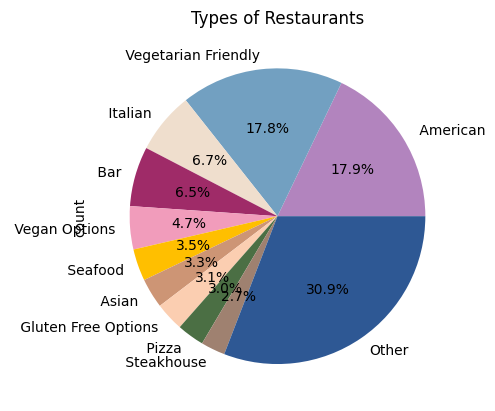

In [111]:
types = restaurants_data['Type'].str.split(',').explode()
type_counts = types.value_counts()
top_10_types = type_counts.head(10)
other_types_count = type_counts[10:].sum()
top_10_types['Other'] = other_types_count

colors = ['#B284BE', '#72A0C1', '#EFDECD', '#9F2B68', '#F19CBB', '#FFBF00', '#CD9575', '#FBCEB1', '#4B6F44', '#9F8170', '#2E5894', '#54626F', '#E97451', '#A3C1AD', '#FFFF99']
top_10_types.plot(kind='pie', autopct='%1.1f%%', colors=colors)
plt.title('Types of Restaurants')
plt.show()


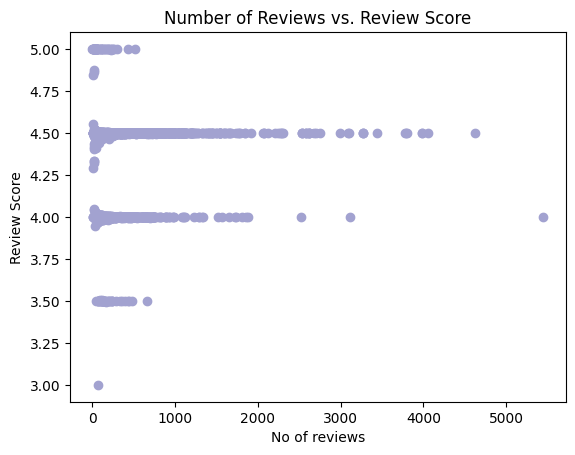

In [112]:
plt.scatter(restaurants_data['No of Reviews'], restaurants_data['Reviews'], color = '#A2A2D0')
plt.title('Number of Reviews vs. Review Score')
plt.xlabel('No of reviews')
plt.ylabel('Review Score')
plt.show()

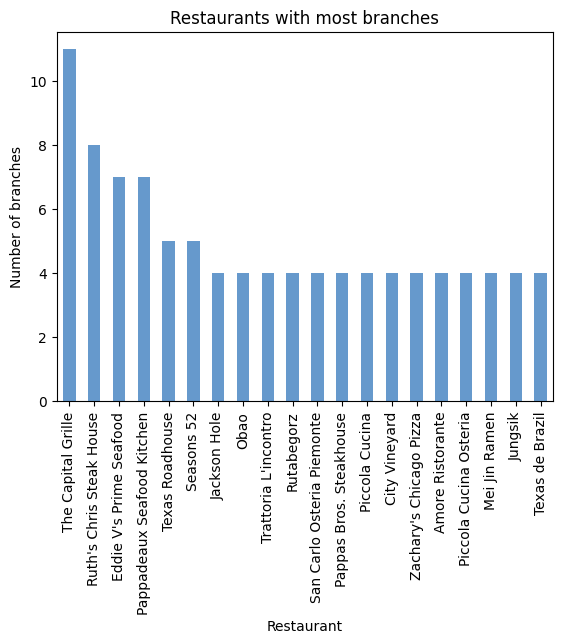

In [113]:
state_counts = filtered_df['Name'].value_counts().head(20)
state_counts.plot(kind='bar', color="#6699CC")
plt.title('Restaurants with most branches')
plt.xlabel('Restaurant')
plt.ylabel('Number of branches')
plt.show()

WordCloud for restaurants that have score gt 4

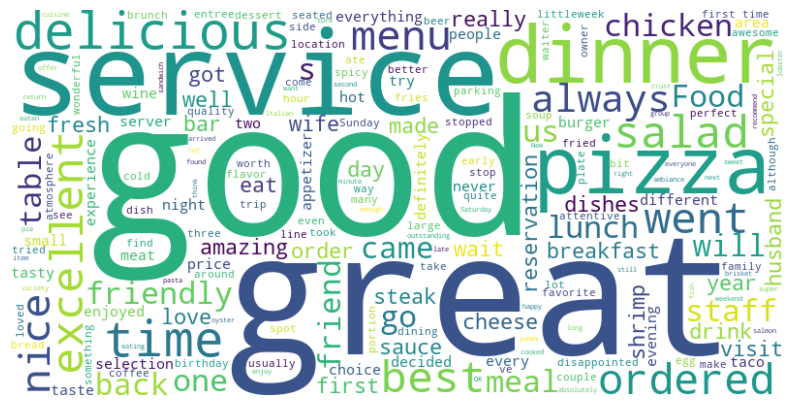

In [114]:
word_data = restaurants_data[restaurants_data['Reviews'] > 4].copy()
comments_not_null = word_data['Comments'].dropna()
comments_text = ' '.join([word for word in comments_not_null if not any(stopword in word for stopword in ['food', 'restaurant', 'place'])])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud for restaurants that have score lt 4

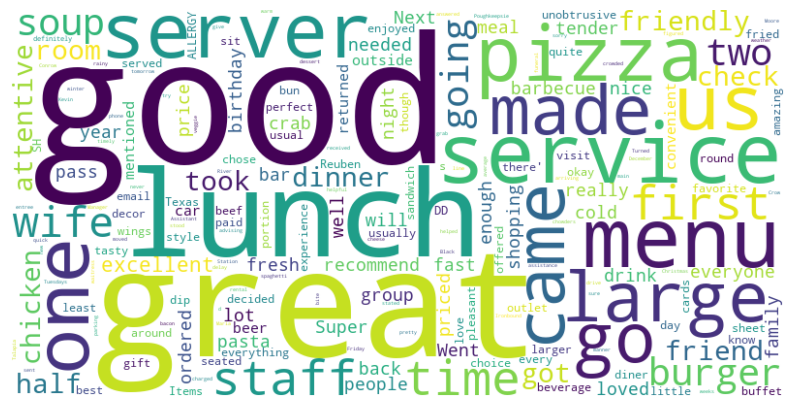

In [115]:
word_data = restaurants_data[restaurants_data['Reviews'] < 4].copy()
comments_not_null = word_data['Comments'].dropna()
comments_text = ' '.join([word for word in comments_not_null if not any(stopword in word for stopword in ['food', 'restaurant', 'place'])])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [116]:
from geopy.exc import GeocoderTimedOut

data = restaurants_data[restaurants_data['Reviews'] == 5].copy()

geolocator = Bing(api_key='AhpwrCFQAHjj_6XelmahpGUxECXe1tonsrdoV2zAc9VJETqAj-6ekcmoMaKv5Ri6')

def geocode_with_timeout(location):
    try:
        return geolocator.geocode(location)
    except GeocoderTimedOut:
        return None

data.loc[:, 'address'] = data['Street Address'] + ", " + data['Location']
data.loc[:, 'new_location'] = data['address'].apply(geocode_with_timeout)
data.loc[:, 'Latitude'] = data['new_location'].apply(lambda x: x.latitude if x is not None else np.nan)
data.loc[:, 'Longitude'] = data['new_location'].apply(lambda x: x.longitude if x is not None else np.nan)

print(data.head())



                          _id                  Name         Street Address  \
29   6481ce0f909234df3c1c6abe            Tabernilla  7124 Bob Bullock Loop   
133  6481ce0f909234df3c1c6b26            Ambrogio15       926 Turquoise St   
263  6481ce0f909234df3c1c6ba8            Very Juice           422 Avenue P   
273  6481ce0f909234df3c1c6bb2  HiroNori Craft Ramen      2222 Michelson Dr   
312  6481ce0f909234df3c1c6bd9              rise n°3      5135 Monahans Ave   

                      Location                                         Type  \
29       Laredo, TX 78041-2080             Spanish, Mediterranean, Wine Bar   
133   San Diego, CA 92109-1186                     Italian, Pizza, Wine Bar   
263    Brooklyn, NY 11223-1935                                                
273      Irvine, CA 92612-1332         Japanese, Asian, Vegetarian Friendly   
312  Fort Worth, TX 76109-1577   French, Vegetarian Friendly, Vegan Options   

     Reviews  No of Reviews  \
29       5.0           39

### Restaurants with score 5 on the USA map:
Only score 5 because it was taking too long to find coordinates for all restaurants.

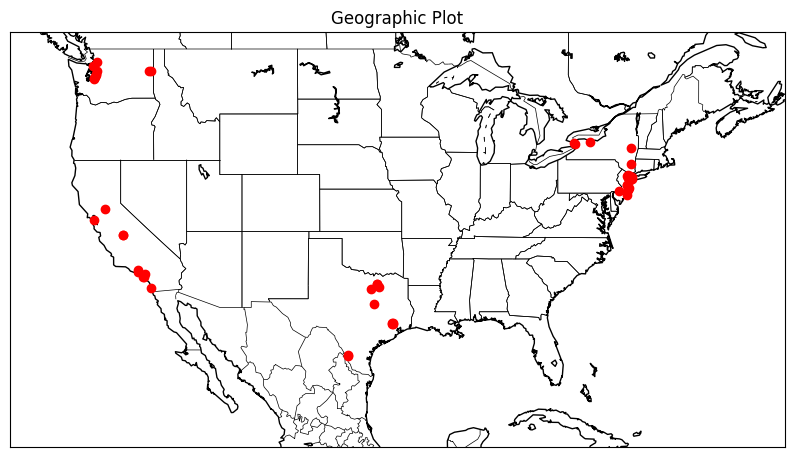

In [117]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

map = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='l')

map.drawcoastlines()
map.drawcountries()
map.drawstates()

x, y = map(data['Longitude'].astype(float), data['Latitude'].astype(float))
map.scatter(x, y, marker='o', color='red', zorder=5)
plt.title('Geographic Plot')
plt.show()


### Restaurants with score 5 on the USA map:
Only score 5 because it was taking too long to find coordinates for all restaurants.

In [118]:
# Create a map centered on the United States
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for index, row in data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        # Add a marker for each location with latitude and longitude
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'],
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(map)

map


In [121]:
full_name = "William White"
state = "ny"
city = "Poughkeepsie"
street = "South Rd Ste C"

url = "http://localhost:8001/restaurant/recommendation/{}/{}/{}/{}".format(
    full_name.replace(" ", "%20"),
    state,
    city.replace(" ", "%20"),
    street.replace(" ", "%20")
)

response = requests.get(url)
new_data = response.json()
Longitude_list = [item['coordinates']['coordinates'][0] if isinstance(item, dict) else np.nan for item in new_data]
Latitude_list = [item['coordinates']['coordinates'][1] if isinstance(item, dict) else np.nan for item in new_data]

new_data = pd.DataFrame(new_data)
new_data['Longitude'] = Longitude_list
new_data['Latitude'] = Latitude_list


In [122]:
location = geolocator.geocode(" ".join([city, ",", state]))
map = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

for index, row in new_data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        # Add a marker for each location with available latitude and longitude
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'],
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(map)

map